# Phương pháp: Collaborative Filtering

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score
from scipy.stats import rankdata
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Playlist data file

In [2]:
filename = "playlist.json" 

**Hàm find_similar_playlists**
- Input:
    - playlist_id: id của playlist (theo thứ tự)
    - similarity_matrix: ma trận độ "giống" giữa các playlist
    - number_of_neighbor_playlists: số lượng playlist tương tự xem xét
- Output:
    - similar_playlist_indices: chỉ số của các bài hát được gợi ý
    - similar_playlist_scores: độ giống nhau của các bài hát được gợi ý

In [35]:
def find_similar_playlists(playlist_id, similarity_matrix, number_of_neighbor_playlists):
    playlist_similarity_scores = similarity_matrix[playlist_id]
    similar_playlist_indices = playlist_similarity_scores.argsort()[:-number_of_neighbor_playlists-2:-1]
    similar_playlist_indices = [index for index in similar_playlist_indices if index != playlist_id]
    similar_playlist_scores = playlist_similarity_scores[similar_playlist_indices]
    return similar_playlist_indices, similar_playlist_scores

- Đọc file
- Tiền xử lý: 
    - Mã hóa các bài hát thành số thứ tự
    - Tạo danh sách ma trận giữa playlist và song

Ví dụ về ma trận giữa playlist và song

![image.png](../../resource/img/playlist_songs.png)

In [4]:
file_data = open(f'./{filename}', 'r')
playlists = json.load(file_data)
all_songs = list(set(song for user in playlists for song in user))
song_to_index = {song: i for i, song in enumerate(all_songs)}
index_to_song = {index: song for song, index in song_to_index.items()}
playlist_songs = np.zeros((len(playlists), len(all_songs))).astype('int')
for i, playlist in enumerate(playlists):
    for song in playlist:
        playlist_songs[i, song_to_index[song]] = 1

**Hàm get_recommend_rank_list:**
- Input: 
    - play_list_id: id của playlist
    - playlist_songs: Ma trận giữa playlist và songs
    - number_of_neighbor_playlists: số lượng playlist tương tự xem xét
- Output:
    - sorted_indices: danh sách đã sắp xếp của các index theo thứ tự gợi ý

Tính cosine_similarity (VD ma trận trên):

![image.png](../../resource/img/CS.png)
![image.png](../../resource/img/similarity_matrix.png)

Giả sử muốn tính điểm gợi ý cho playlist 1 từ playlist 2 và playlist3:
- Lấy độ giống nhau giữa playlist 1 và playlist 2 nhân với ma trận playlist 2 
- Làm tương tự với playlist 3,  thu được ma trận:

![image.png](../../resource/img/step1.png)

Tính số điểm gợi ý cho các bài mà playlist 1 chưa có

![image.png](../../resource/img/step2.png)

In [33]:
def get_recommend_rank_list(play_list_id, playlist_songs = playlist_songs, number_of_neighbor_playlists = 18):
    # Calculate cosine similarity matrix using training data
    similarity_matrix = cosine_similarity(playlist_songs)
    similar_playlist_indices, similar_playlist_scores = find_similar_playlists(play_list_id, similarity_matrix, number_of_neighbor_playlists)
    recommendation_points = np.sum(playlist_songs[similar_playlist_indices] * similar_playlist_scores[:, np.newaxis], axis = 0)
    total_recommend_list_point = np.sum(similar_playlist_scores)
    sorted_indices = np.argsort(recommendation_points)[::-1]
    return sorted_indices

## Đánh giá:
### Độ đo MMR 

In [ ]:
mean_mmr_arr = {}

In [ ]:
for num_neighbors in range(20, 51, 5):
    total_mrr = 0
    num_playlists = len(playlist_songs)
    for i, vector_track in enumerate(playlist_songs):
        print(num_neighbors, i)
        playlist_songs_copy = np.copy(playlist_songs)
        indices_of_ones = np.where(vector_track == 1)[0]
        random_index = 0
        if len(indices_of_ones) > 0:
            random_index = np.random.choice(indices_of_ones)
            playlist_songs_copy[i, random_index] = 0
        rank = np.where(get_recommend_rank_list(play_list_id = i, 
                                                playlist_songs = playlist_songs_copy,
                                                number_of_neighbor_playlists = num_neighbors)==random_index)[0]
        reciprocal_rank = 1 / (rank[0] + 1) if len(rank) > 0 else 0
        total_mrr += reciprocal_rank
        clear_output(wait = True)
    mean_mrr = total_mrr / num_playlists
    mean_mmr_arr[num_neighbors] = mean_mrr

In [51]:
mean_mmr_arr

{1: 0.01427409526572659,
 2: 0.02480872528198442,
 3: 0.039346293049444404,
 4: 0.03737729277988237,
 5: 0.03985499213920587,
 6: 0.05040205198691727,
 7: 0.036488672582423026,
 8: 0.046885513221254733,
 9: 0.05517955940443204,
 10: 0.047763357252824254,
 11: 0.044993702302380825,
 12: 0.039203683714517164,
 13: 0.05190614714238842,
 14: 0.04353405391623913,
 15: 0.05466542257753918,
 16: 0.053784939641279,
 17: 0.05782099595864262,
 18: 0.058558395596120964,
 19: 0.054260157152162064,
 20: 0.05264040795780811,
 25: 0.05353750886692245,
 30: 0.04780282123900077,
 35: 0.04859110520251957,
 40: 0.04657943212250356}

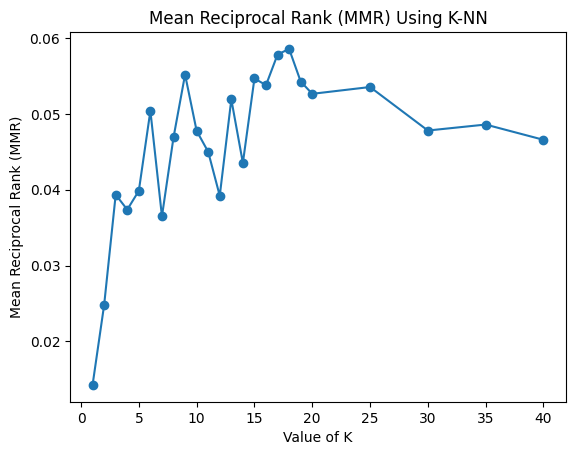

In [52]:
playlist_ids = list(mean_mmr_arr.keys())
mean_mmr_values = list(mean_mmr_arr.values())

plt.plot(playlist_ids, mean_mmr_values, marker='o', linestyle='-')
plt.title('Mean Reciprocal Rank (MMR) Using K-NN')
plt.xlabel('Value of K')
plt.ylabel('Mean Reciprocal Rank (MMR)')
plt.show()